# 3. Develop time series forecasting models to predict future product prices

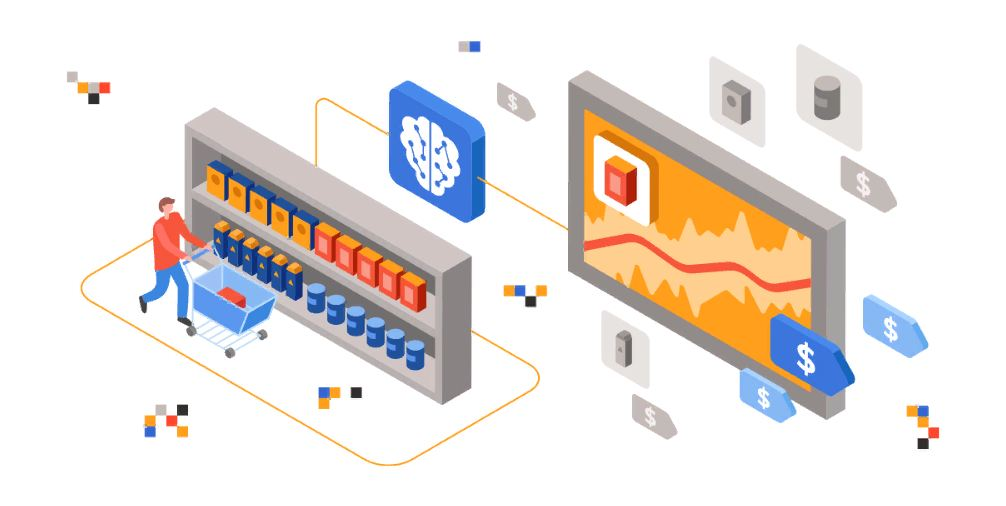

## Проблема
Одной из важнейших задач для любой розничной торговой компании является анализ эффективности работы ее магазинов. Главная задача, с которой сталкивается любой розничный магазин,-это заранее спрогнозировать объем продаж и запасов, необходимых в каждом магазине, чтобы избежать перерасхода и недозагрузки. Это помогает бизнесу обеспечить наилучший опыт работы с клиентами и избежать потерь, обеспечивая тем самым устойчивость магазина к эксплуатации.

## Данные

Вам предоставляются исторические данные о продажах для 1115 магазинов Rossmann. Задача состоит в том, чтобы спрогнозировать столбец "Продажи" для тестового набора. Обратите внимание, что некоторые магазины в наборе данных были временно закрыты на ремонт.

* Id - идентификатор, представляющий двойник (Хранилище, Дата) в тестовом наборе.
* Store - уникальный идентификатор для каждого магазина
* Sales - оборот за любой данный день (это то, что вы прогнозируете)
* Customers - количество клиентов в данный день
* Open - индикатор того, был ли магазин открыт: 0 = закрыт, 1 = открыт
* StateHoliday - указывает на государственный праздник. Обычно все магазины, за редким исключением, закрыты в праздничные дни. Обратите внимание, что все школы закрыты в праздничные и выходные дни. a = государственный праздник, b = Пасхальный праздник, c = Рождество, 0 = Нет
* SchoolHoliday - указывает, повлияло ли (Магазин, Дата) на закрытие государственных школ
* StoreType - различает 4 различные модели магазинов: a, b, c, d
* Assortment - описывает уровень ассортимента: a = базовый, b = дополнительный, c = расширенный
* CompetitionDistance - расстояние в метрах до ближайшего магазина конкурентов
* CompetitionOpenSince[Месяц/год] - дает приблизительный год и месяц времени открытия ближайшего конкурента
* Promo - указывает, проводит ли магазин промо-акцию в этот день.
* Promo2 - Promo2-это непрерывная и последовательная акция для некоторых магазинов: 0 = магазин не участвует, 1 = магазин участвует
* Promo2Since[Year/Week] - описывает год и календарную неделю, когда магазин начал участвовать в Promo2
* PromoInterval - описывает последовательные интервалы запуска Promo2, называя месяцы начала акции заново. Например, "Февраль,май,август, Ноябрь" означает, что каждый раунд начинается в феврале, мае, августе, ноябре любого данного года для этого магазина

In [90]:
# используем методологию Prophet
!pip install fbprophet

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from fbprophet import Prophet

In [92]:
train = pd.read_csv('train.csv')
train.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [93]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


* Всего 9 колонок
* 8 функций, каждая из которых содержит 1017209 строк данных
* 1 целевая переменная (sales)
* Средняя сумма продаж в день = 5773 евро, минимальная сумма продаж в день = 0, максимальная сумма продаж в день = 41551
* Среднее количество клиентов = 633, минимальное количество клиентов = 0, максимальное количество клиентов = 7388

In [94]:
store = pd.read_csv('Store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [95]:
store.info()
store.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


**Обратите внимание, что предыдущий фрейм данных включает транзакции, записанные в день (в миллионах), этот фрейм данных включает в себя только информацию об уникальных 1115 магазинах, которые являются частью этого исследования в среднем, дистанция между конкурентами составляет 5404 метра (5,4 км)**

## Первичный анализ данных

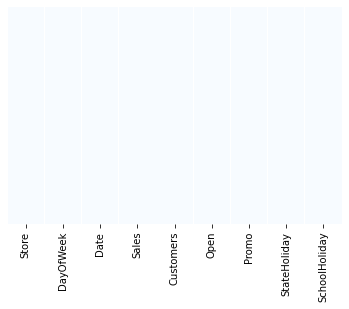

In [96]:
# Давайте посмотрим, есть ли у нас недостающие данные
sns.heatmap(train.isnull(),yticklabels=False,cmap='Blues',cbar=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99c2268d90>,
      dtype=object)

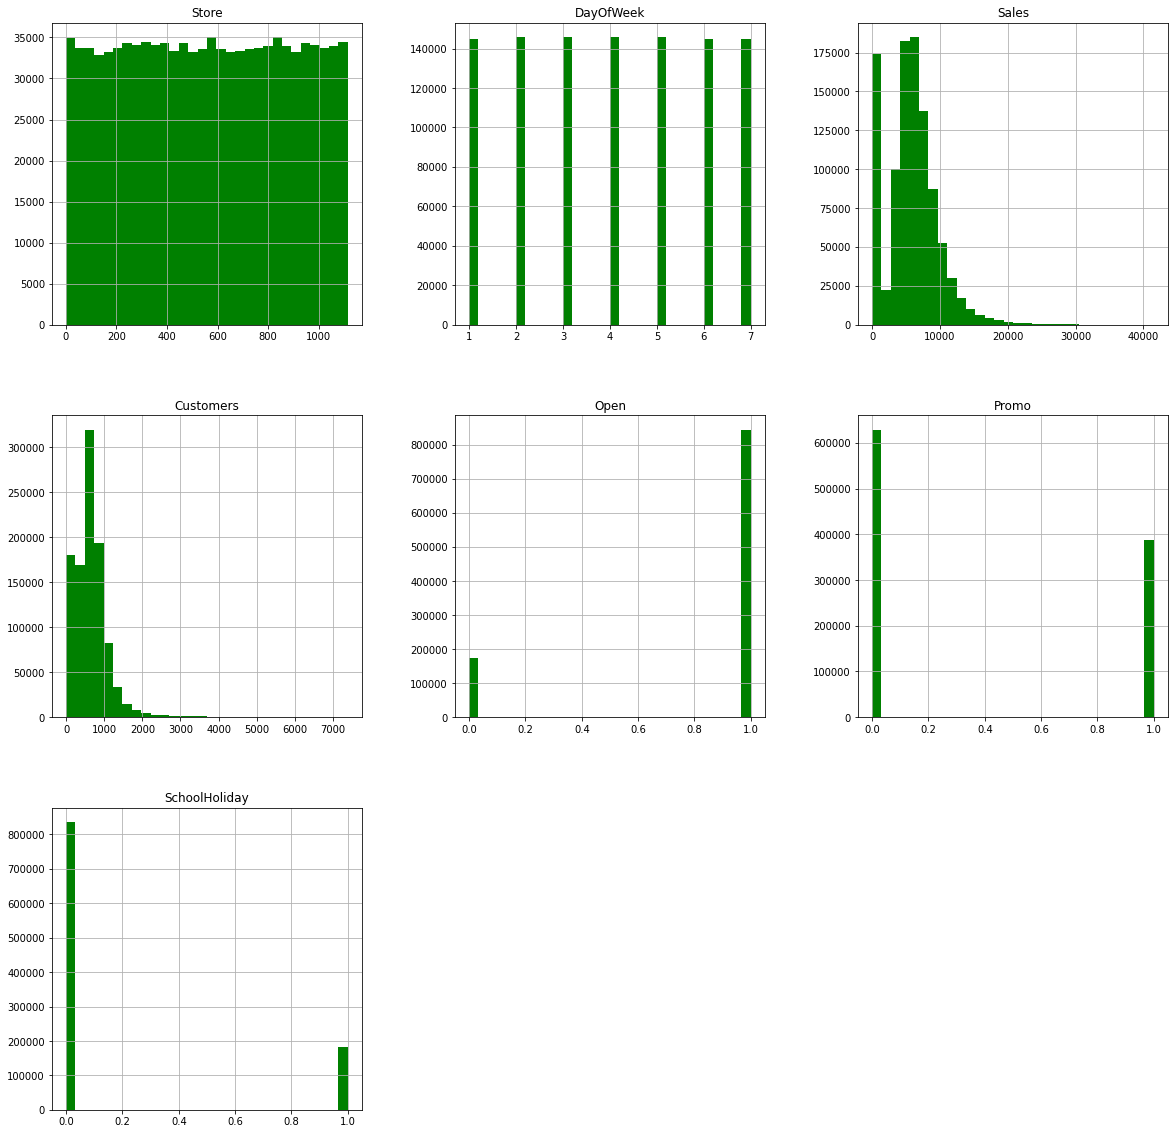

In [97]:
train.hist(bins=30,color='g',figsize = (20,20))

* В среднем 600 клиентов в день, максимум-4500 (обратите внимание, что мы не видим выброса в 7388!)
* Данные одинаково распределены по разным дням недели (~150000 наблюдений х 7 дней = ~1,1 миллиона наблюдений)
* Магазины открыты ~80% времени
* Данные равномерно распределяются между всеми магазинами (без смещения)
* Промо-акции занимали ~40% времени
* Средний объем продаж около 5000-6000 евро
* Школьные каникулы проходятся на примерно 18% времени

In [98]:
# Давайте посмотрим, сколько магазинов открыто и закрыто!
train['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [99]:
# открытые магазины с нулевыми продажами
train[(train.Open != 0) & (train.Sales == 0)].value_counts().sum()

54

In [100]:
# Оставим только дни в которые магазин был открыт и были продажи, для чистоты эксперимента
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
train.shape
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [101]:
# добавим новую переменную. Средняя сумма продажи на покупателя 
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844338.000000
mean          9.493641
std           2.197448
min           2.749075
25%           7.895571
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

В среднем клиенты тратят около 9,50$ в день.

In [102]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [103]:
# недостающие значения в CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Очевидно, что эта информация просто отсутствует в данных. Никакой особой закономерности не наблюдалось. В этом случае имеет полный смысл заменить NaN медианными значениями (которые в два раза меньше среднего).

In [104]:
# заполните NaN медианным значением 
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [105]:
# В остальных случаях заменим пропуски 0
store.fillna(0, inplace = True)

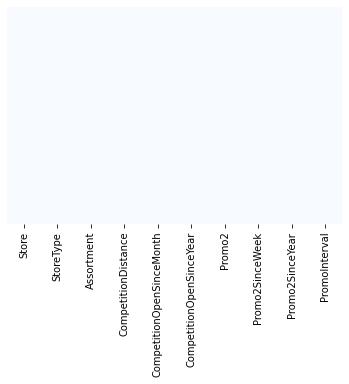

In [106]:
sns.heatmap(store.isnull(),cbar=False,cmap='Blues',yticklabels=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99c1b5c610>,
      dtype=object)

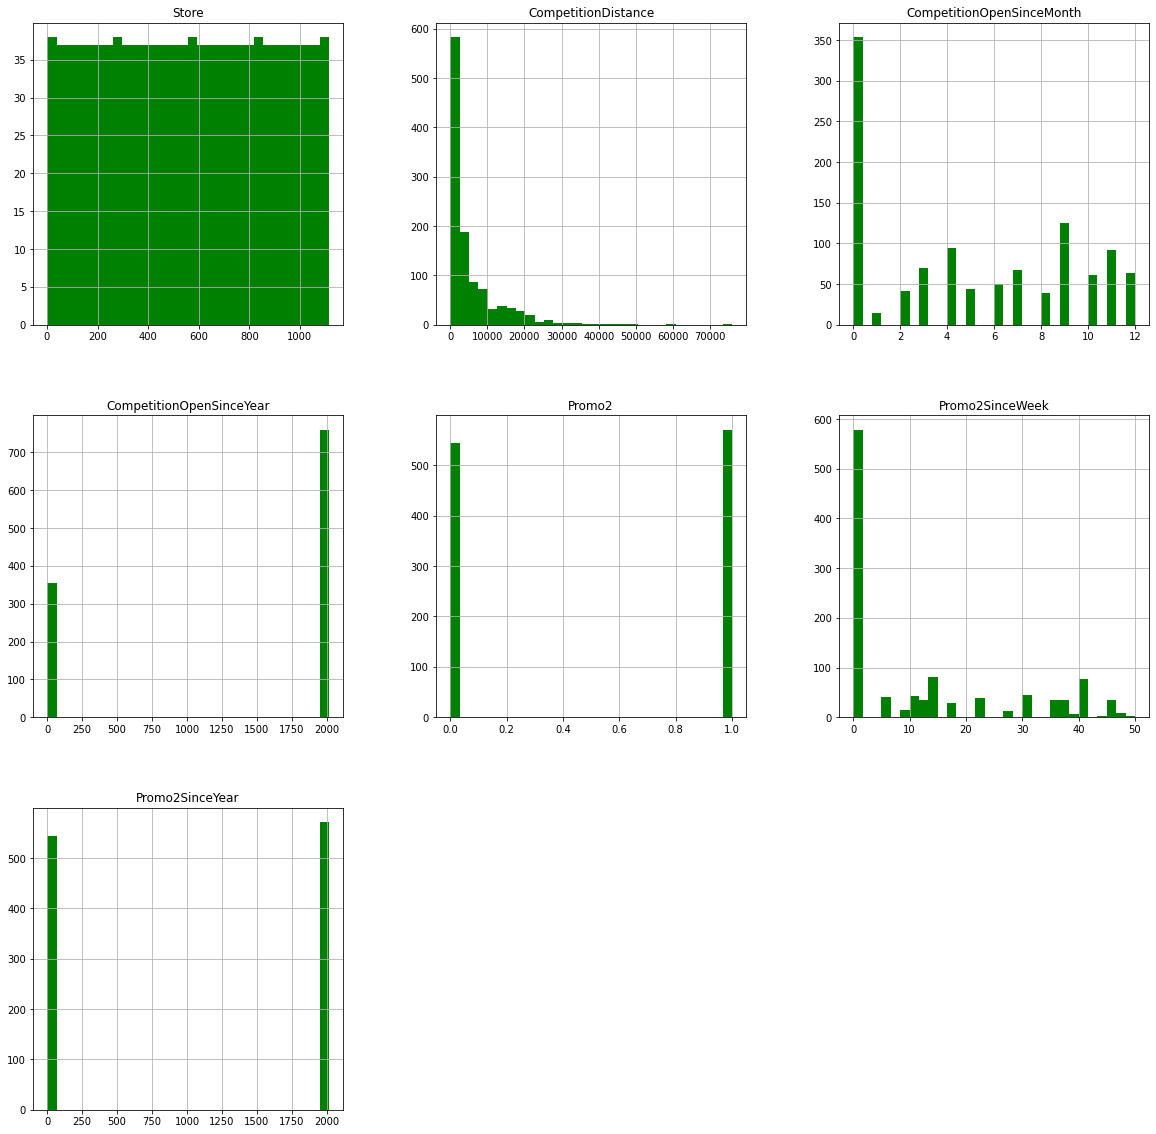

In [107]:
store.hist(figsize=(20,20),color='g',bins=30)

In [108]:
# обьеденим фреймы данных
train_store = pd.merge(train, store, how = 'inner', on = 'Store')
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [109]:
train_store['Year'] = pd.DatetimeIndex(train_store['Date']).year
train_store['Month'] = pd.DatetimeIndex(train_store['Date']).month
train_store['Day'] = pd.DatetimeIndex(train_store['Date']).day
train_store['WeekOfYear'] = pd.DatetimeIndex(train_store['Date']).weekofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



**В этом разделе мы подробно рассмотрим различные типы магазина и то, как распределяется между ними основная метрика продаж.**

In [110]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


Тип магазина b имеет самый высокий средний показатель продаж среди всех остальных, однако у нас гораздо меньше данных по нему. Итак, давайте посмотрим общую сумму продаж и клиентов, чтобы увидеть, какой тип магазина является наиболее продаваемым и переполненным:

In [111]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Очевидно, что магазины типа А является наиболее продаваемым и переполненным. storeType D выходит на второе место как по продажам, так и по покупателям. А как насчет периодов дат? Фасетная сетка лучший инструмент для этой задачи:

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



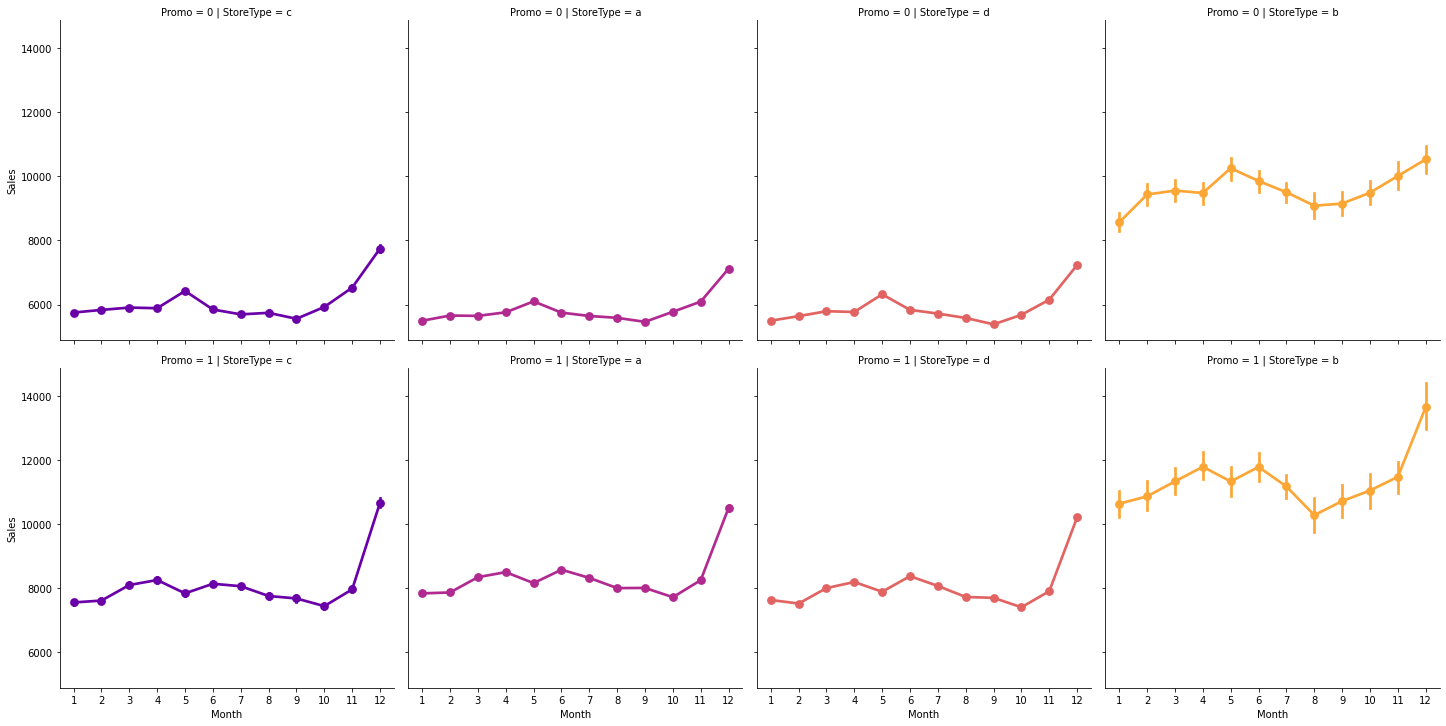

In [112]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo'
               ) 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



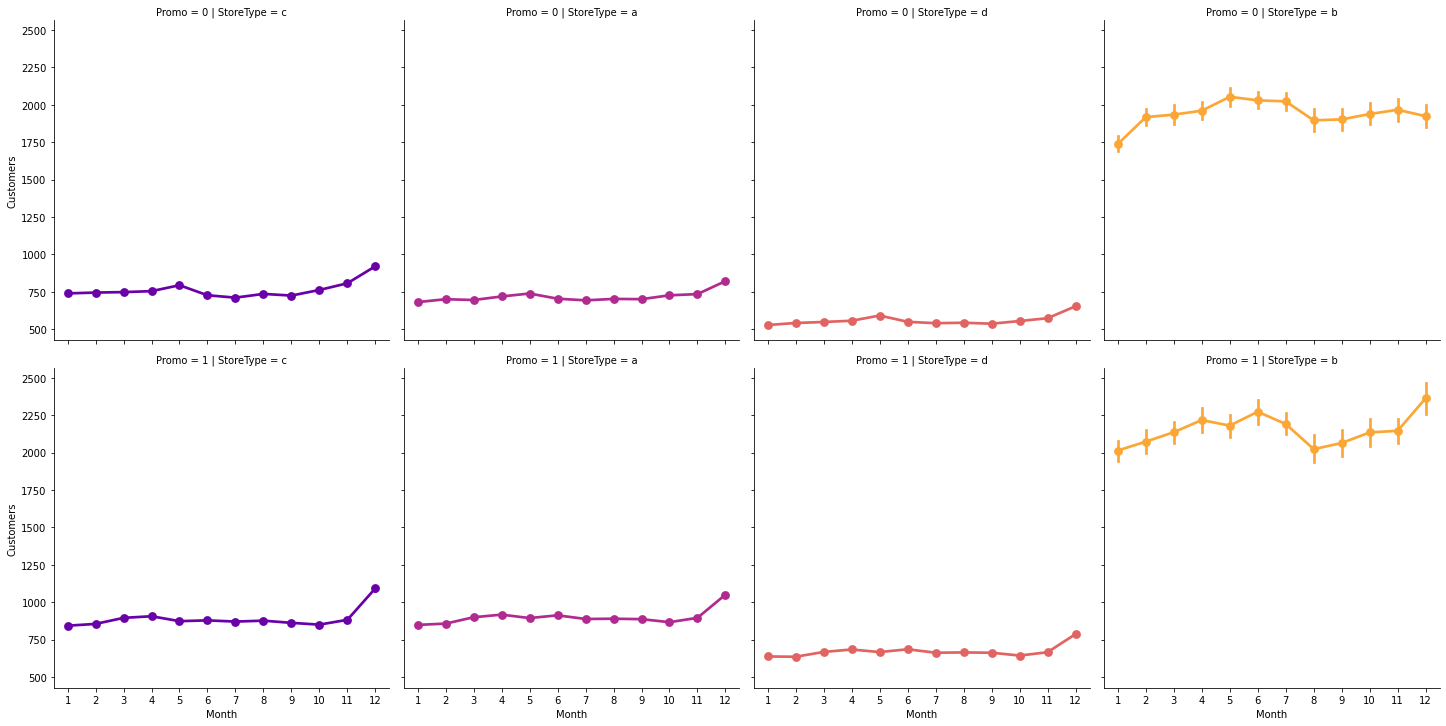

In [113]:
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo'
               ) 

Все типы магазинов следуют одной и той же тенденции, но в разных масштабах в зависимости от наличия промо-акции и самого типа магазина (случай Б).

**Уже сейчас мы видим, что продажи растут к рождественским праздникам. Но о сезонности и тенденциях мы поговорим позже в разделе "Анализ временных рядов".**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



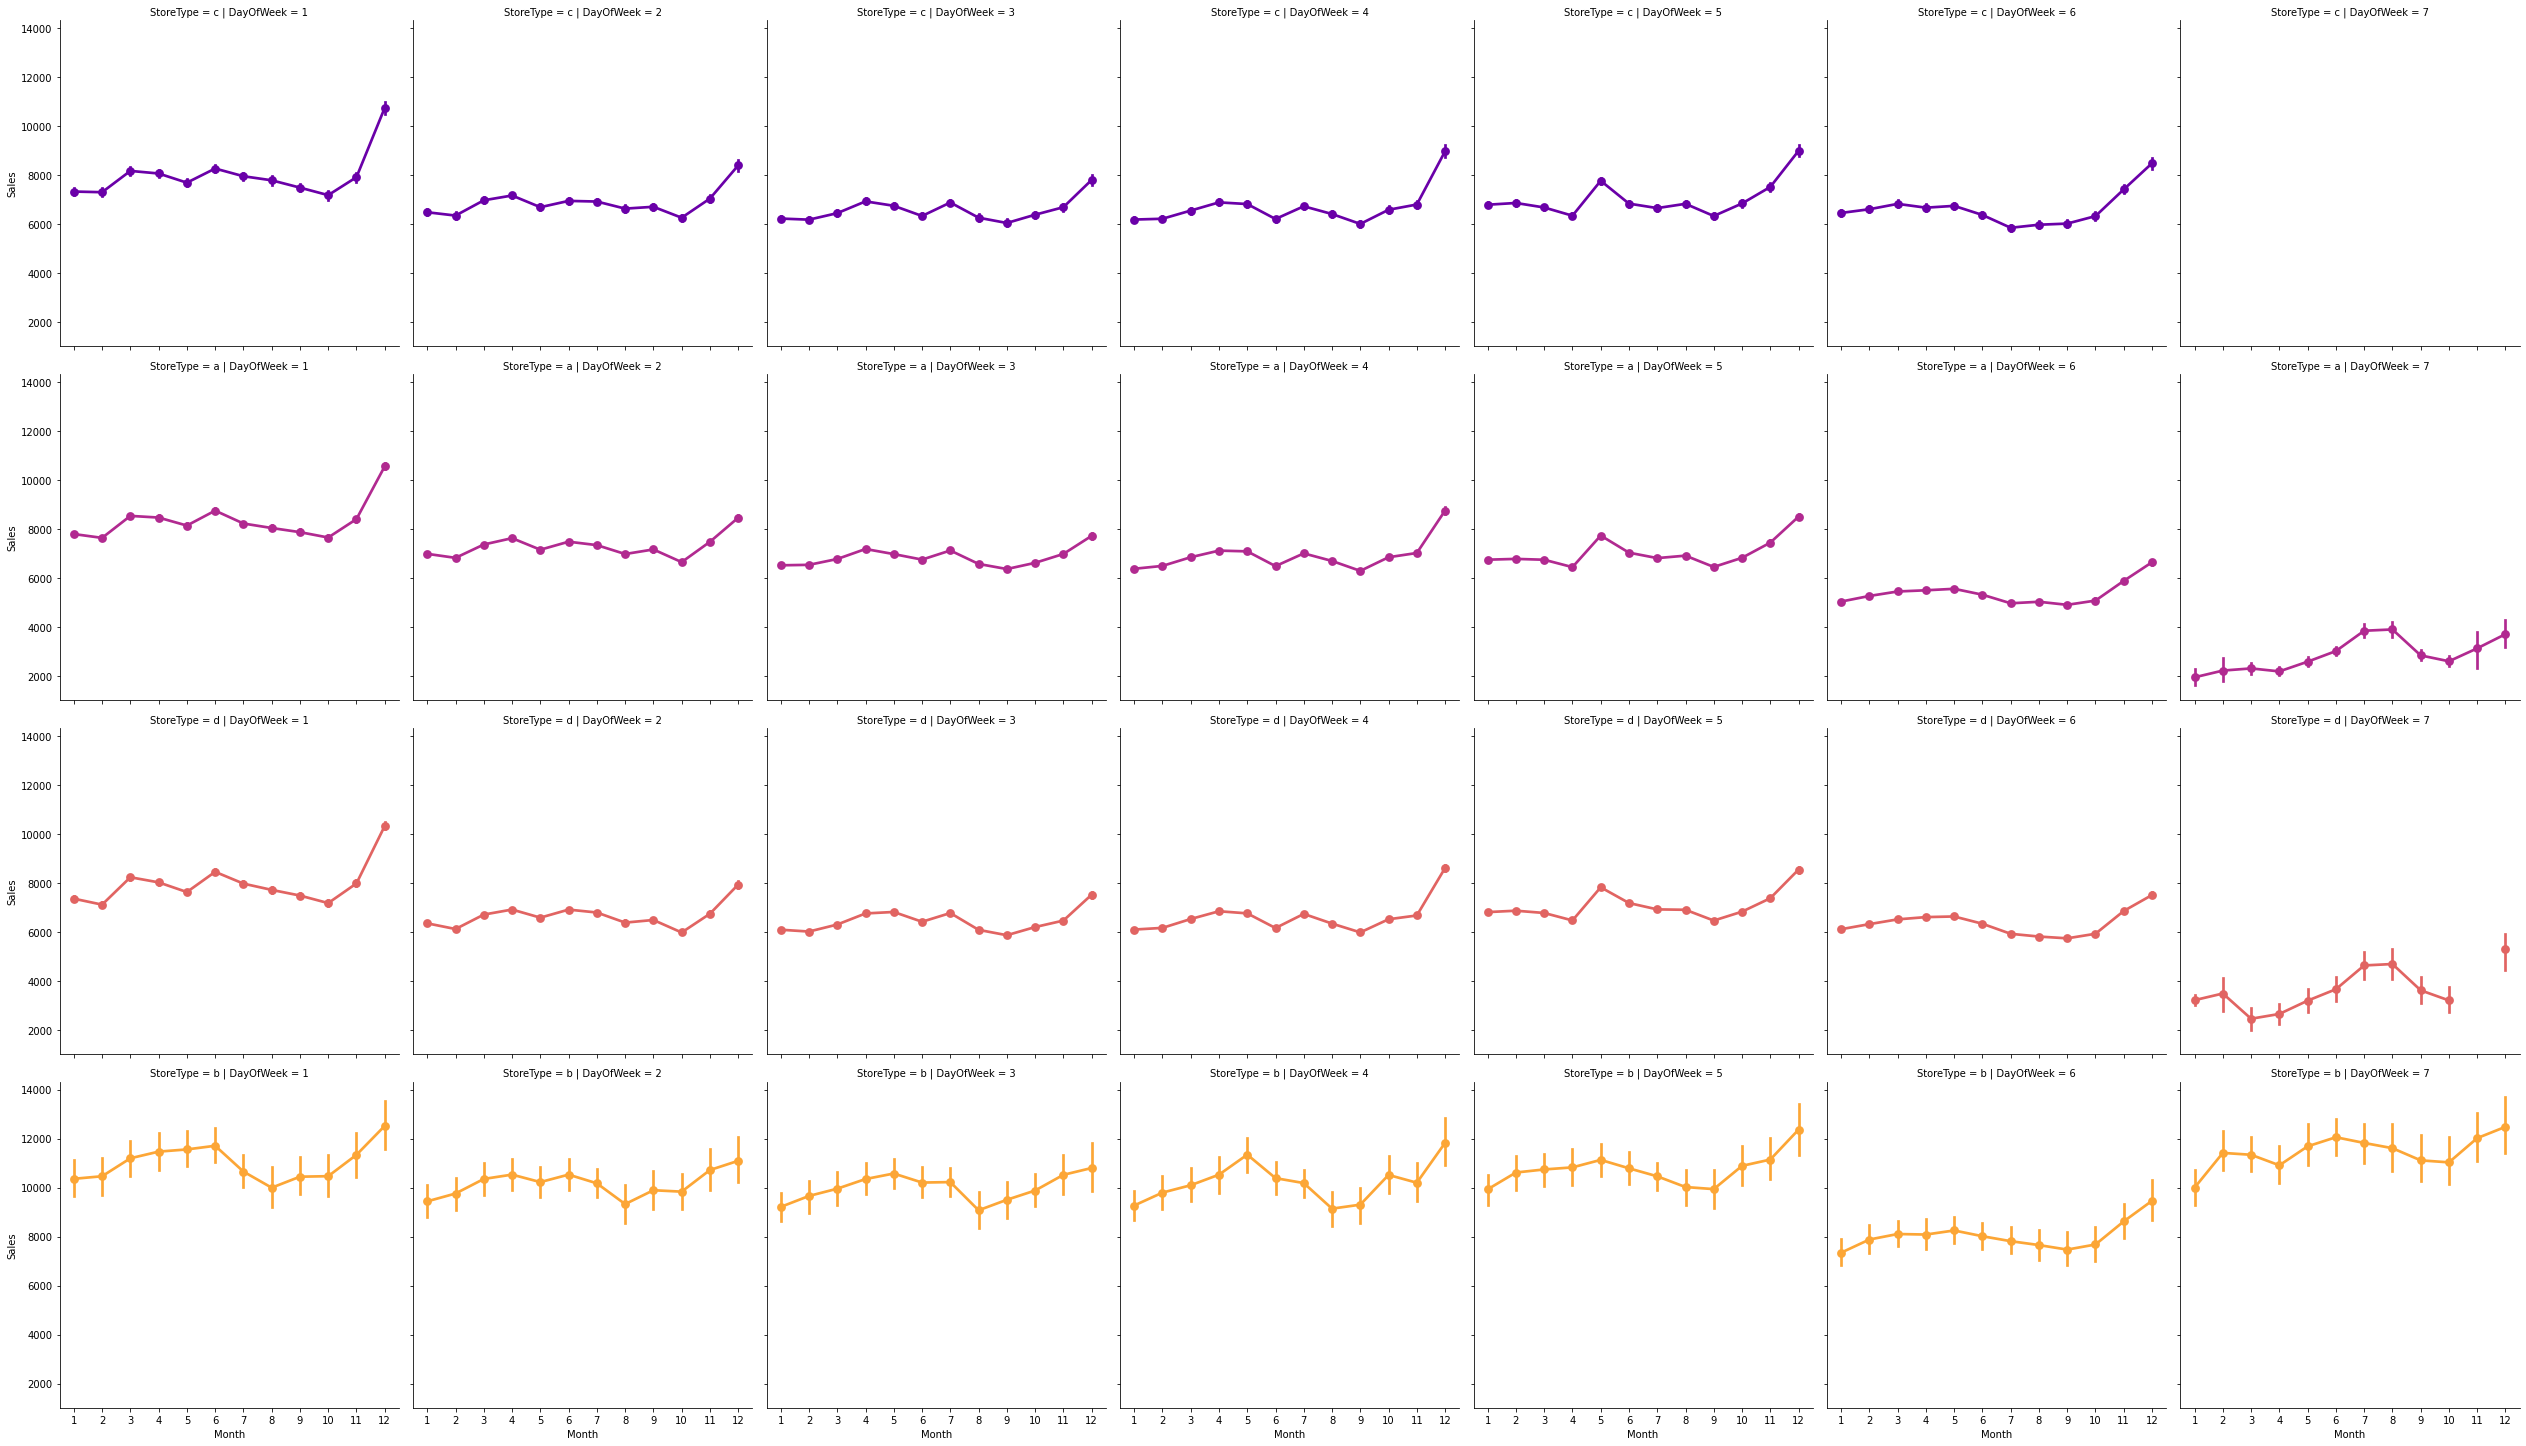

In [114]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', 
               ) 

Мы видим, что все магазины типа С закрыты по воскресеньям, тогда как другие большую часть времени открыты. Интересно, что магазины типа " Д " закрыты по воскресеньям только с октября по декабрь.

Кстати, какие магазины открыты по воскресеньям?

In [115]:
# Кстати, какие магазины открыты по воскресеньям?
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

Чтобы завершить наш предварительный анализ данных, мы можем добавить переменные, описывающие период времени, когда открывалимь конкуренты и проводились промо-акции:

In [116]:
# время открытия конкурента (в месяцах)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# время промо акции
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# заманяем nan на 0
train_store.fillna(0, inplace = True)

# среднее время PromoOpen и время CompetitionOpen для каждого типа магазина
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


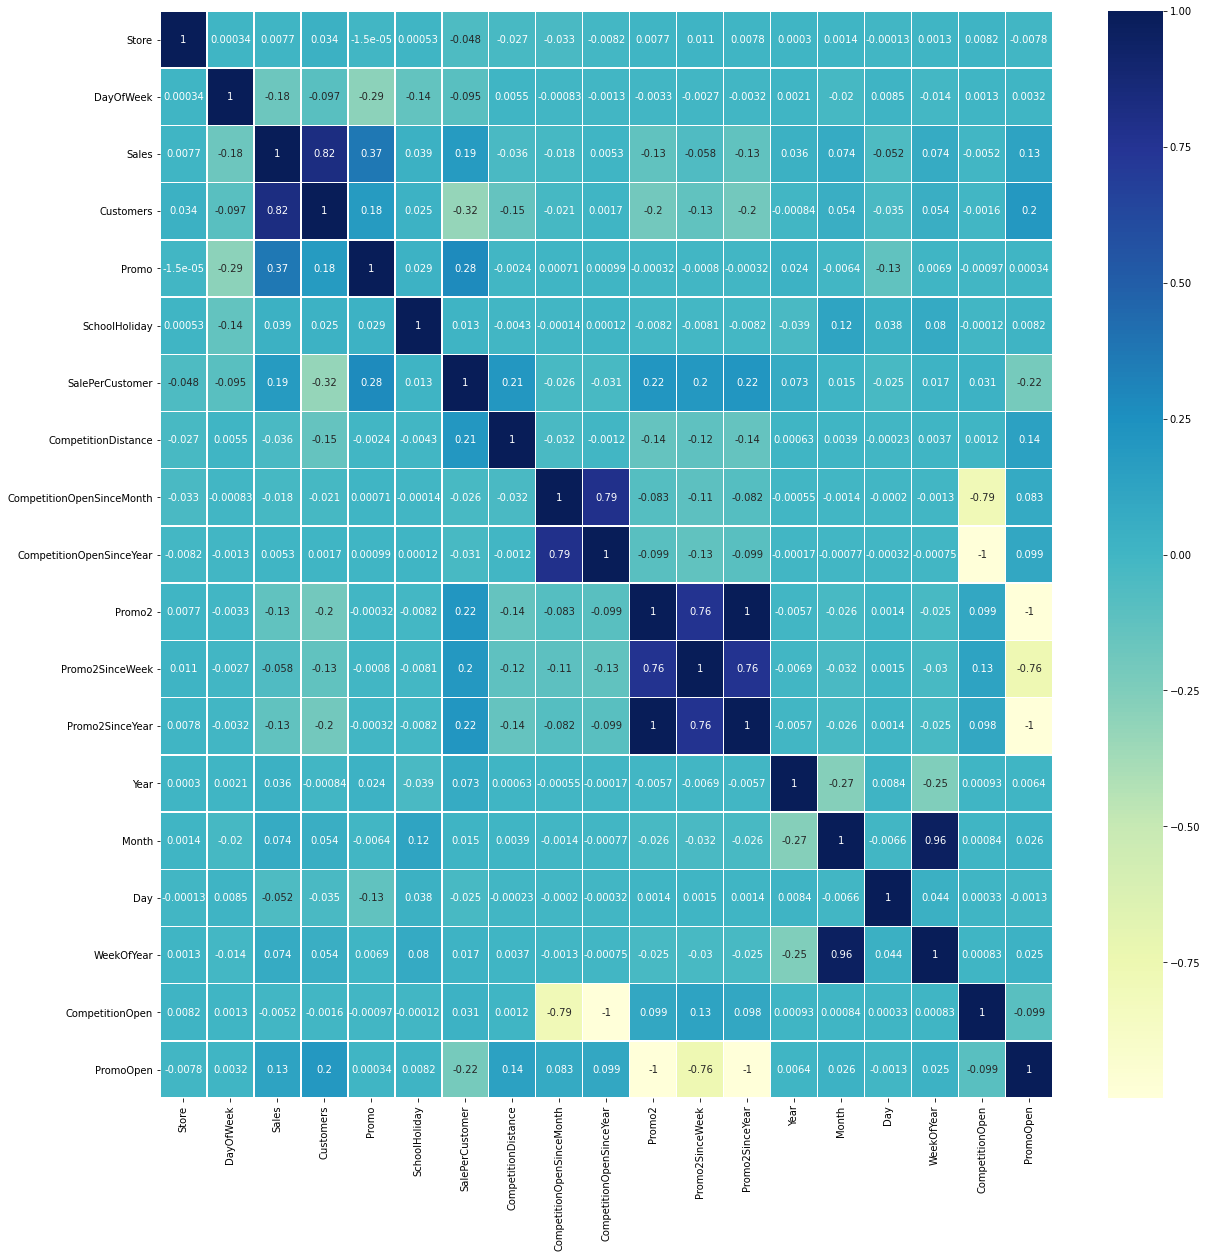

In [117]:
corr_all = train_store.drop('Open', axis = 1).corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_all,annot=True,cmap="YlGnBu",linewidths=.5)

Как уже упоминалось ранее, мы имеем сильную положительную корреляцию между продажами и покупателями магазина. Мы также можем наблюдать положительную корреляцию между тем, что в магазине была запущена акция (Промо) и количеством Покупателей.

Однако, как только магазин продолжает последовательную акцию (Promo2), количество Покупателей и Продаж, кажется, остается прежним или даже уменьшается, что описывается бледной отрицательной корреляцией на тепловой карте. Такая же отрицательная корреляция наблюдается между наличием акции в магазине и днем недели.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



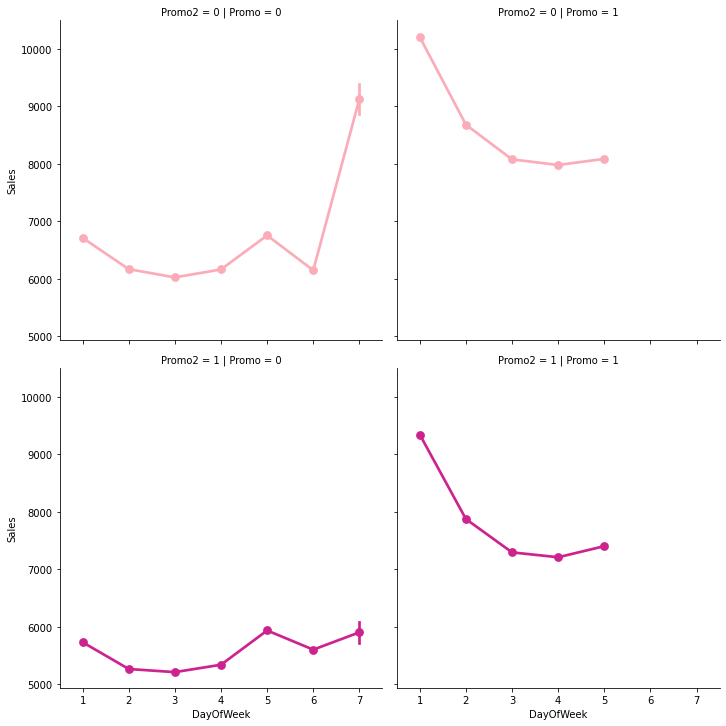

In [118]:
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

* В случае отсутствия акции, как Promo, так и Promo2, продажи, как правило, достигают пика в воскресенье. Хотя следует отметить, что storeType C не работает по воскресеньям. Таким образом, это в основном данные из хранилищ типа A, B и D.
* Напротив, магазины, которые проводят акцию, как правило, делают большую часть продаж в понедельник. Этот факт может быть хорошим показателем для маркетинговых кампаний Rossmann. Та же тенденция наблюдается и в магазинах, которые одновременно проводят обе акции (Promo и Promo2).
* Promo2 сам по себе, по-видимому, не коррелирует с каким-либо значительным изменением объема продаж.

## Выводы первичного анализа
* Самый продаваемый и переполненный тип магазина-А.
* Лучший тип магазина "SalePerCustomer" D указывает на более высокую корзину покупателя. Чтобы извлечь выгоду из этого факта, Rossmann может рассмотреть возможность предложения большего разнообразия своих продуктов.
* Низкая сумма SalePerCustomer для магазина типа B указывает на возможный факт, что люди покупают там в основном "мелкие" вещи. Несмотря на то, что этот тип магазина генерировал наименьшее количество продаж и клиентов за весь период, он демонстрирует большой потенциал.
* Клиенты, как правило, покупают больше, когда есть одна акция (Promo), и по воскресеньям, когда нет никакой акции вообще
* Promo2 сам по себе, по-видимому, не коррелирует с каким-либо значительным изменением объема продаж.

## Анализ временных рядов 

In [119]:
def sales_prediction(Store_ID, sales_df, periods):
  sales_df = sales_df[sales_df['Store'] == Store_ID]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model    = Prophet()
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods=periods)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure2  = model.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


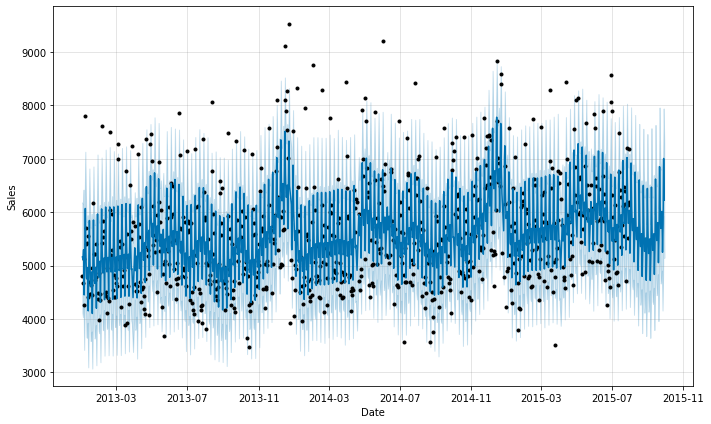

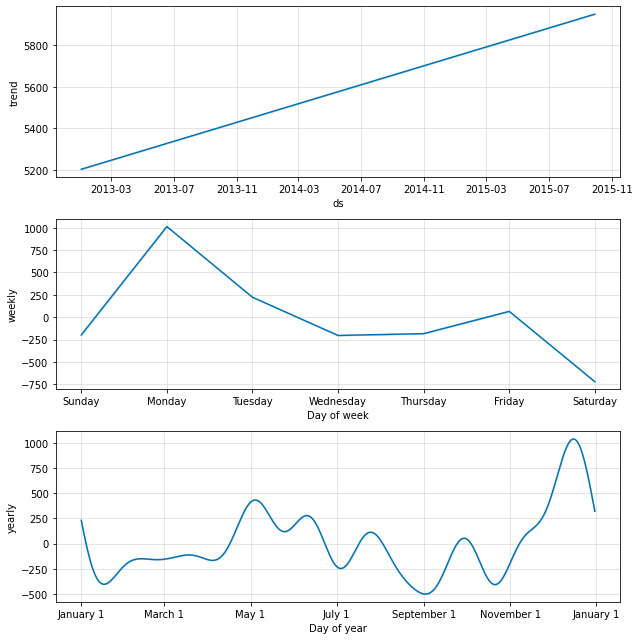

In [120]:
sales_prediction(10, train_store, 60)

In [121]:

def sales_prediction_better(Store_ID, sales_df, holidays, periods):
  # Функция, которая принимает StoreID и возвращает два столбца даты/продаж в формате Prophet
  # Форматирование данных в соответствии с Prophet

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model = Prophet(interval_width = 0.95, 
                        holidays = holidays)
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods = 6*7)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure2  = model.plot_components(forecast)

In [122]:
# Все даты относящиеся к школьным празникам
school_holidays = train_store[train_store['SchoolHoliday'] == 1].loc[:, 'Date'].values
school_holidays.shape

(163445,)

In [123]:
# Национальные праздники
state_holidays = train_store[(train_store['StateHoliday'] == 'a') | (train_store['StateHoliday'] == 'b') | (train_store['StateHoliday'] == 'c')  ].loc[:, 'Date'].values
state_holidays.shape

(910,)

In [124]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                                'holiday': 'school_holiday'})

In [125]:
school_state_holidays = pd.concat((state_holidays, school_holidays))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


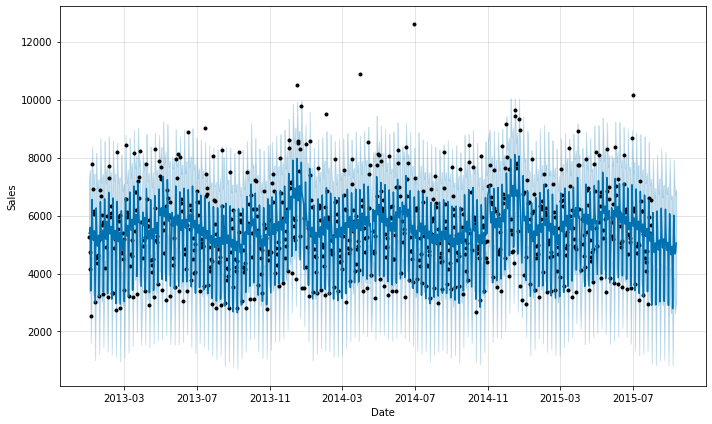

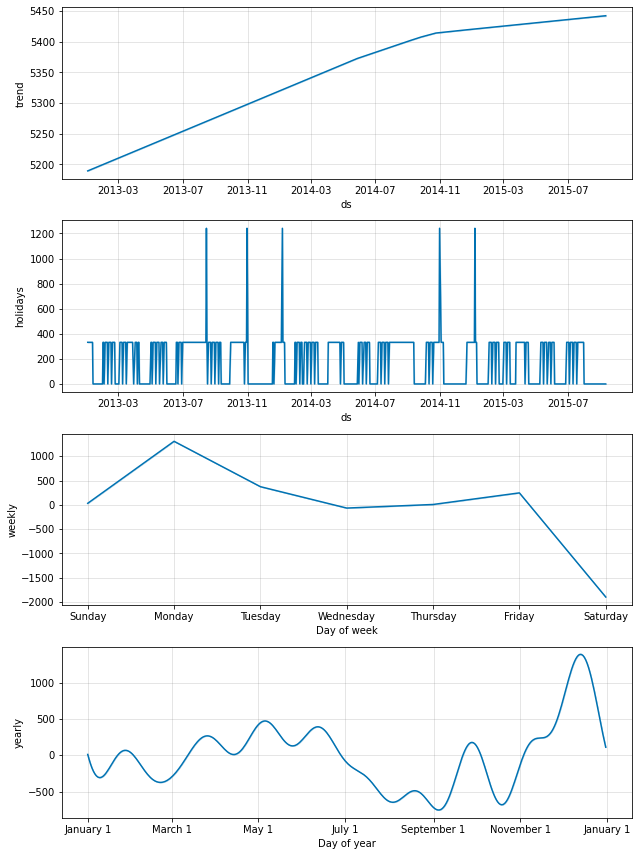

In [126]:
sales_prediction_better(14, train_store, school_state_holidays, 60)

# Вывод
* первый граыик показывает предсказаный обьем продаж по всем магазинам на билайшие 60 дней, судя по циклам графика до этого момента, прогноз достаточно доставерный
* второй график показывает, что ежемесячные продажи магазина № 1 увеличиваются с течением времени
* третий показывает пробелы holiays, включенные в модель.
* четвертый график подчеркивает тот факт, что еженедельный объем продаж на прошлой неделе достигает пика к понедельнику следующей недели
* пятый график показывает, что самый оживленный сезон приходится на рождественские праздники.

**P.S.Результаты прогнозов хорошие. Использование Facebook prophet достаточно просто просто, вот что мне в нем нравится. Но я все равно хотел бы решить эту задачу с помощью ARIMA & LSTM и сравнить результаты**